## RNNによる文章生成
* seq2seqというニューラルネットワークを使用する
* これを使用することで機械翻訳やチャットボットなどの様々なアプリケーションで利用することができる。

In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
%matplotlib inline
os.chdir("./deep-learning-from-scratch-2-master/")
from common import *

In [2]:
from common.functions import softmax
from ch06.rnnlm import Rnnlm
from ch06.better_rnnlm import BetterRnnlm

class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]
        
        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())
            
            sampled = np.random.choice(len(p), size=1, p=p)
            if(skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))
        return word_ids

In [3]:
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data("train")
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()

start_word = "you"
start_id = word_to_id[start_word]
skip_words = ["N", "<unk>", "$"]
skip_ids = [word_to_id[w] for w in skip_words]

word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(" <eos>", ".\n")
print(txt)

you cancers bag seldom equitec disaster rest innocent competitiveness adopting payable anderson february balance prospective diversified guilty traveled altogether underwritten allied software armonk scoring antonio stressing sentenced trip guests massages become blunt power aimed citing warnings column bonn eat arising processors birth isolated margin mike prohibition tele-communications deviation undervalued charter reasons deficit deutsche sci plants passes thrown herald bidding exchange southam sudden ventures jolt trump fame lotus outlets grabbed quack unsecured slid cleared tied surprises richfield haul unilab recognition solidarity retire anniversary presented annuities theories internationally disks ghosts saul breath peter parcel yielded vowed pattern offensive seniors mayor succeed gaining


In [4]:
corpus, word_to_id, id_to_word = ptb.load_data("train")
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params("./ch06/Rnnlm.pkl")

start_word = "you"
start_id = word_to_id[start_word]
skip_words = ["N", "<unk>", "$"]
skip_ids = [word_to_id[w] for w in skip_words]

word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(" <eos>", ".\n")
print(txt)

you 'll take their own.
 the changes could recognized inches to the current wage on the minority of retail birds.
 this minister contained has come only from nine years and foam to a extension of more walking.
 identified he wrote the accord called working an agreement for a fast-growing meeting today for years.
 but now half of the planner whose washington-based offerings and television businesses firms with raising certain internal international loans.
 the experiment have turned restricted for the leaders of the certain warming said mr. roman wrote last month.
 mr. jones has told


### seq2seq
* 二つのRNNを利用する
* Encoder-Decoderモデルとも言われている。

In [5]:
from dataset import sequence

(X_train, t_train), (X_test, t_test) = sequence.load_data("addition.txt", seed=0)
char_to_id, id_to_char = sequence.get_vocab()

print(X_train.shape, t_train.shape)
print(X_test.shape, t_test.shape)

print(X_train[0])
print(t_train[0])

print("".join([id_to_char[c] for c in X_train[0]]))
print("".join([id_to_char[c] for c in t_train[0]]))

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[11 12  1  2  0  0 11]
[ 6  7  1 12  5]
846+118
_964 


### seq2seqの実装
#### Encoderクラス
* Embedding層とLSTM層によって構成される。
* Embedding層では文字を文字ベクトルに変換
* LSTMレイヤでは時間方向に隠れ状態とセルを出力、上方向には隠れ状態のみを出力。その後廃棄
* 最後の文字を処理した後、LSTMの隠れ状態hを出力。このhがDecoderに渡される。

In [6]:
from common.time_layers import *
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

In [7]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled


### seq2seqクラス

In [8]:
from common.base_model import *
class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

In [9]:
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
os.chdir("./ch07/")
from peeky_seq2seq import PeekySeq2seq

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.53
| epoch 1 |  iter 41 / 351 | time 1[s] | loss 2.17
| epoch 1 |  iter 61 / 351 | time 2[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 3[s] | loss 1.92
| epoch 1 |  iter 101 / 351 | time 4[s] | loss 1.87
| epoch 1 |  iter 121 / 351 | time 5[s] | loss 1.85
| epoch 1 |  iter 141 / 351 | time 6[s] | loss 1.83
| epoch 1 |  iter 161 / 351 | time 7[s] | loss 1.79
| epoch 1 |  iter 181 / 351 | time 8[s] | loss 1.77
| epoch 1 |  iter 201 / 351 | time 9[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 10[s] | loss 1.76
| epoch 1 |  iter 241 / 351 | time 11[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 12[s] | loss 1.76
| epoch 1 |  iter 281 / 351 | time 13[s] | loss 1.75
| epoch 1 |  iter 301 / 351 | time 14[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 15[s] | loss 1.75
| epoch 1 |  iter 341 / 351 | time 16[s] | loss 1.74
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+8

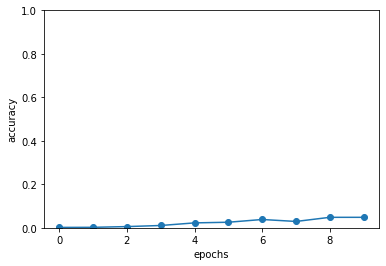

In [10]:
# データセットの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# Reverse input? =================================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 10
max_grad = 5.0

# Normal or Peeky? ==============================================
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()

### seq2seqの改良
#### 入力データの反転(先ほどのコードでreveseをTrueに変更)
* https://arxiv.org/pdf/1409.3215.pdf こちらで紹介されていた
#### 覗き見
* Encoderには入力データを固定長のベクトルhに変換（この中にDecoderにとって重要な情報がすべて詰まっている）
* LSTMレイヤのみがベクトルhを利用している。
* https://arxiv.org/pdf/1406.1078.pdf　覗き見の論文
* 重要な情報を共有する

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.52
| epoch 1 |  iter 41 / 351 | time 1[s] | loss 2.17
| epoch 1 |  iter 61 / 351 | time 2[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 3[s] | loss 1.91
| epoch 1 |  iter 101 / 351 | time 4[s] | loss 1.87
| epoch 1 |  iter 121 / 351 | time 5[s] | loss 1.86
| epoch 1 |  iter 141 / 351 | time 5[s] | loss 1.84
| epoch 1 |  iter 161 / 351 | time 6[s] | loss 1.80
| epoch 1 |  iter 181 / 351 | time 7[s] | loss 1.78
| epoch 1 |  iter 201 / 351 | time 8[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 9[s] | loss 1.77
| epoch 1 |  iter 241 / 351 | time 11[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 11[s] | loss 1.75
| epoch 1 |  iter 281 / 351 | time 12[s] | loss 1.74
| epoch 1 |  iter 301 / 351 | time 13[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 14[s] | loss 1.74
| epoch 1 |  iter 341 / 351 | time 15[s] | loss 1.73
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84

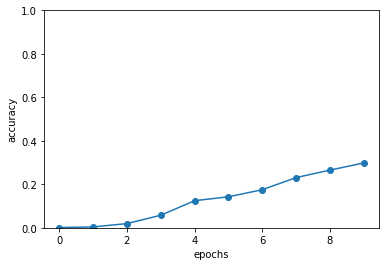

In [11]:
# データセットの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# Reverse input? =================================================
is_reverse = True  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 10
max_grad = 5.0

# Normal or Peeky? ==============================================
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.57
| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.48
| epoch 1 |  iter 41 / 351 | time 1[s] | loss 2.20
| epoch 1 |  iter 61 / 351 | time 2[s] | loss 1.99
| epoch 1 |  iter 81 / 351 | time 3[s] | loss 1.89
| epoch 1 |  iter 101 / 351 | time 4[s] | loss 1.82
| epoch 1 |  iter 121 / 351 | time 5[s] | loss 1.82
| epoch 1 |  iter 141 / 351 | time 7[s] | loss 1.80
| epoch 1 |  iter 161 / 351 | time 8[s] | loss 1.79
| epoch 1 |  iter 181 / 351 | time 9[s] | loss 1.78
| epoch 1 |  iter 201 / 351 | time 10[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 11[s] | loss 1.76
| epoch 1 |  iter 241 / 351 | time 12[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 13[s] | loss 1.75
| epoch 1 |  iter 281 / 351 | time 14[s] | loss 1.74
| epoch 1 |  iter 301 / 351 | time 15[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 16[s] | loss 1.73
| epoch 1 |  iter 341 / 351 | time 17[s] | loss 1.73
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1013
---
Q 582+

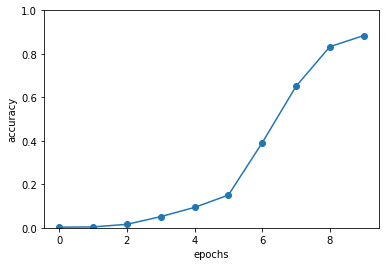

In [12]:
# データセットの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# Reverse input? =================================================
is_reverse = True  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 10
max_grad = 5.0

# Normal or Peeky? ==============================================
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()